In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os

from sklearn.preprocessing import LabelEncoder
from functions import equal, find_nearest, impute_immediate_mean, impute_mean_day, daylight_savings_shift, clean_weather

## Energy Dataset

In [65]:
energy = pd.read_csv('../data/energy_dataset.csv')

# Convert Time to datetime, set to index
energy['time'] = energy['time'].apply(lambda x: x[:13])
energy['time'] = pd.to_datetime(energy['time'], format="%Y-%m-%d %H" )
#energy.set_index('time', inplace=True)
index=9024
energy.loc[index:index+48, ['price day ahead', 'time']]

,price day ahead,time
9024,58.23,2016-01-12 00:00:00
9025,55.00,2016-01-12 01:00:00
9026,51.44,2016-01-12 02:00:00
9027,50.39,2016-01-12 03:00:00
9028,50.39,2016-01-12 04:00:00
9029,53.50,2016-01-12 05:00:00
9030,58.26,2016-01-12 06:00:00
9031,64.99,2016-01-12 07:00:00
9032,68.33,2016-01-12 08:00:00
9033,66.64,2016-01-12 09:00:00


In [ ]:
# Load and combine all day ahead price data into single dataframe
price_ahead = pd.DataFrame()

for file in os.listdir('../data/day ahead price'):
    load = pd.read_csv(f'../data/day ahead price/{file}')
    price_ahead = pd.concat([price_ahead,load])

# Rename to price_forecast_tomorrow
price_ahead.rename(columns={'Day-ahead Price [EUR/MWh]':'price_forecast_tomorrow'}, inplace=True)

# Convert Time to datetime
price_ahead['time'] = price_ahead['MTU (CET)'].apply(lambda x: x[:13])
price_ahead['time'] = pd.to_datetime(price_ahead['time'], format="%d.%m.%Y %H" )

# Set index to the time col
price_ahead.set_index('time', inplace=True)

# Drop irrelevant cols
price_ahead.drop(columns= ['BZN|ES', 'MTU (CET)'], inplace=True)

In [33]:
energy = pd.read_csv('../data/energy_dataset.csv')

# Convert Time to datetime, set to index
energy['time'] = energy['time'].apply(lambda x: x[:13])
energy['time'] = pd.to_datetime(energy['time'], format="%Y-%m-%d %H" )
energy.set_index('time', inplace=True)


#energy = pd.read_csv('../data/energy_dataset.csv')

# Chop of nanoseconds, and convert to datetime, reset index
#energy.time = pd.to_datetime(energy.time.apply(lambda x: x[:-6]), )
#energy.set_index('time', inplace=True)

# Get rid of columns that do not contain any information
energy = energy.drop(columns = energy.loc[:,energy.nunique()<=1].columns)

# Create start stop variable for indices
start = dt.datetime(2015, 1, 1)
stop = dt.datetime(2018, 12, 31, 23)

# Create continuous list of indices by hour
yr15_18 = pd.DataFrame(index = pd.date_range(start, stop, freq='H' ))

# join existing data on the complete list of indices
energy = energy.join(yr15_18,how='right')

# Loop through each column and impute missing values
for col in energy.columns:
    
    # Get the indices of missing values in this column
    indices = energy.loc[energy[col].isna()].index
    
    # For each missing value, impute the mean of closest known values
    for i in indices:
        energy.loc[i, col] = impute_immediate_mean(energy[col], i)
        
# Get indices of duplicates
indices = energy.loc[energy.index.value_counts()>1].index.unique()

# average duplicate values for each column
for col in energy.columns:
    for i in indices:
        energy.loc[i, col] = round(energy.loc[i,col].mean(),1)
        

# Drop duplicates
energy.drop_duplicates(inplace=True)

# Create total generation column summing all generation sources
energy['generation total'] = energy.loc[:,:'generation wind onshore'].sum(axis=1)

# Create diff column (difference between total generation and actual load)
energy['diff'] = energy['generation total'] - energy['total load actual']

columns = ['generation biomass',
           'generation fossil brown coal/lignite',
           'generation fossil hard coal',
           'generation fossil oil',
           'generation hydro run-of-river and poundage',
           'generation hydro water reservoir',
           'generation nuclear',
           'generation other',
           'generation other renewable',
           'generation solar',
           'generation waste',
           'generation wind onshore',]
for col in columns:
    flag_indices = energy.loc[energy['diff']<-15000].index
    for i in flag_indices:
        energy.loc[i, col] = impute_immediate_mean(energy[col], i)

In [34]:
# Get Shift cols
shift_cols = ['forecast solar day ahead', 
              'forecast wind onshore day ahead', 
              'total load forecast', 
              'price day ahead', 
              'price actual']

# Copy actual price to new series
tomorrow = energy[shift_cols].copy()

# Shift the actual price index by a single day backwards
tomorrow = tomorrow.shift(-1, freq='D')

# Copy the df and merge tomorrows price into each row
energy = energy.join(tomorrow, how='inner', rsuffix='_tomorrow')

energy.rename(columns={'forecast solar day ahead_tomorrow':'solar_forecast_tomorrow',
                       'forecast wind onshore day ahead_tomorrow': 'wind_forecast_tomorrow',
                       'total load forecast_tomorrow': 'load_forecast_tomorrow',
                       'price day ahead_tomorrow':'price_forecast_tomorrow',
                       'price actual_tomorrow': 'price_tomorrow'},
              inplace=True)

# Remove price actual from shift_cols
shift_cols.remove('price actual')

# Remove shifted cols and rename price actual
energy.drop(columns=shift_cols, inplace=True)
energy.rename(columns={'price actual': 'price_actual'},inplace=True)

In [35]:
energy

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation wind onshore,total load actual,price_actual,generation total,diff,solar_forecast_tomorrow,wind_forecast_tomorrow,load_forecast_tomorrow,price_forecast_tomorrow,price_tomorrow
2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,6378.0,25385.0,65.41,28251.0,2866.0,5.0,13329.0,27309.0,10.00,64.02
2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,5890.0,24382.0,64.92,27818.0,3436.0,35.0,12718.0,25397.0,7.00,58.46
2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,5461.0,22734.0,64.48,26796.0,4062.0,43.0,12375.0,23640.0,5.00,54.70
2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,5238.0,21286.0,59.32,25223.0,3937.0,32.0,11524.0,22638.0,4.00,54.91
2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,4935.0,20264.0,56.04,24620.0,4356.0,31.0,11310.0,22238.0,4.00,53.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 19:00:00,266.0,0.0,5730.0,1510.0,228.0,1.0,1158.0,3422.0,6071.0,56.0,...,5129.0,29221.0,72.37,24009.0,-5212.0,96.0,3253.0,30619.0,68.85,77.02
2018-12-30 20:00:00,275.0,0.0,5683.0,1556.0,221.0,1.0,1155.0,3501.0,6070.0,57.0,...,5406.0,30042.0,73.35,24364.0,-5678.0,51.0,3353.0,29932.0,68.40,76.16
2018-12-30 21:00:00,275.0,0.0,5859.0,1616.0,216.0,1.0,1167.0,4248.0,6070.0,57.0,...,5193.0,30229.0,73.64,25143.0,-5086.0,36.0,3404.0,27903.0,66.88,74.30
2018-12-30 22:00:00,283.0,0.0,5660.0,1610.0,215.0,1.0,1160.0,3757.0,6071.0,57.0,...,4912.0,29145.0,71.92,24171.0,-4974.0,29.0,3273.0,25450.0,63.93,69.89


## Weather Data

In [2]:
cities = ['madrid', 'seville', 'barcelona', 'bilbao', 'valencia']
dfs = []
for city in cities:
    
    # Read in city dataframe
    city_df = pd.read_csv(f'../data/weather/{city}.csv', index_col=0)

    # Clean the madrid data
    city_df = clean_weather(city_df)

    # Rename columns
    city_df.columns = city_df.columns + f'_{city}'
    
    dfs.append(city_df)
    
# Create daterange
index = pd.date_range(start=dt.datetime(2015,1,1),
                      end = dt.datetime(2021,12,31, 23),
                      freq='H')
range_ = pd.DataFrame(index=index)

# Join to date range in weather data
weather = range_.join([dfs[0], dfs[1], dfs[2], dfs[3], dfs[4]])

# Drop unnecessary columns
weather.drop(columns=['index_madrid', 'index_seville', 'index_barcelona',
                      'index_bilbao', 'index_valencia'],
             inplace=True)

# Get list of categoricals and continuous variables
categorical = weather.select_dtypes(include='object').columns
continuous = weather.select_dtypes(exclude='object').columns

# Impute the mean day for continuous variables with 12 or more missing
for col in continuous:
    impute_mean_day(weather, col, 12)

# Interpolate remaining continuous Nans
weather.loc[:, continuous] = weather.loc[:, continuous].interpolate(limit=12)

# Back fill categorical nans
weather.loc[:,categorical] = weather[categorical].fillna(value='unknown')

# Back fill remaining nans (first five rows of dataset)
weather = weather.fillna(method='bfill')

# Drop duplicates in the index
weather.reset_index(inplace=True)
weather.drop_duplicates(subset='index', inplace=True)
weather.set_index('index', inplace=True)

# Drop precips cols
weather.drop(columns = weather.filter(regex='precips').columns, inplace=True)

## Cross Border Transmission Data

In [3]:
# Read in France Border Data
france = pd.DataFrame()
portugal = pd.DataFrame()

for file in os.listdir('../data/cross_border/france'):
    data = pd.read_csv(f'../data/cross_border/france/{file}')
    data.drop_duplicates(subset='Time (CET)', inplace=True)
    france = pd.concat([france, data],axis=0)

# Convert Time to datetime
france['time'] = france['Time (CET)'].apply(lambda x: x[:13])
france['time'] = pd.to_datetime(france['time'], format="%d.%m.%Y %H")
france = france.set_index('time').drop(columns='Time (CET)')

# Read in Portugal Border Data
for file in os.listdir('../data/cross_border/portugal'):
    data = pd.read_csv(f'../data/cross_border/portugal/{file}')
    data.drop_duplicates(subset='Time (CET)', inplace=True)
    portugal = pd.concat([portugal, data],axis=0)
portugal['time'] = portugal['Time (CET)'].apply(lambda x: x[:13])
portugal['time'] = pd.to_datetime(portugal['time'], format="%d.%m.%Y %H")
portugal = portugal.set_index('time').drop(columns='Time (CET)')

# Join France and Portugal Data
border = portugal.join(france)
border.fillna(method='ffill', inplace=True)
cols = dict(zip(border.columns,['transmission_ps', 
                                'transmission_sp', 
                                'transmission_fs',
                                'transmission_sf']))

border.rename(columns=cols, inplace=True)

## Generation

In [4]:
gen = pd.DataFrame()
for file in os.listdir('../data/generation'):
    load = pd.read_csv(f'../data/generation/{file}')
    load.drop_duplicates(subset='MTU', inplace=True)
    gen = pd.concat([gen, load], axis=0)
    
# Get rid of columns that do not contain any information
gen = gen.drop(columns = gen.loc[:,gen.nunique()<=1].columns)

# Convert Time to datetime
gen['time'] = pd.to_datetime(gen.MTU.apply(lambda x: x[:13]))

# Set index to the time col
gen.set_index('time', inplace=True)

# Drop MTU col
gen.drop(columns='MTU', inplace=True)

# Rename cols
gen.columns = gen.columns.map(lambda x: ('generation '+ x[:-26]).lower())
gen.rename(columns={'generation hydro pumped storage ': 'generation hydro pumped storage consumption'},
           inplace=True)

# Impute Immediate Mean for NaNs
for col in gen.columns:
    indices = gen.loc[gen[col].isna()].index
    for i in indices:
        gen.loc[i,col] = impute_immediate_mean(gen[col], i)

## Load Forecast and Actual

In [5]:
load_forecast = pd.DataFrame()
for file in os.listdir('../data/load'):
    load = pd.read_csv(f'../data/load/{file}')
    if load.columns[0] == 'Time (CET/CEST)':
        load.rename(columns={'Time (CET/CEST)':'Time (CET)'}, inplace=True)
    load.drop_duplicates(subset=load.columns[0], inplace=True)
    load_forecast = pd.concat([load_forecast, load], axis=0)

# Convert Time to datetime
load_forecast['time'] = pd.to_datetime(load_forecast['Time (CET)'].apply(lambda x: x[:13]),
                                       format="%d.%m.%Y %H")

# Set index to the time col
load_forecast.set_index('time', inplace=True)

# Drop 'Time (CET)' col
load_forecast.drop(columns='Time (CET)', inplace=True)

# Rename cols
load_forecast.rename(columns = {'Day-ahead Total Load Forecast [MW] - BZN|ES':'total load forecast',
                                'Actual Total Load [MW] - BZN|ES':'total load actual'}, 
                     inplace=True)

# Impute Immediate Mean for NaNs
for col in load_forecast.columns:
    indices = load_forecast.loc[load_forecast[col].isna()].index
    for i in indices:
        load_forecast.loc[i,col] = impute_immediate_mean(load_forecast[col], i)
        

# Shift forecast col, rename, drop original forecast,
load_forecast = load_forecast.join(load_forecast['total load forecast'].shift(-1, freq='D'), rsuffix='_tomorrow')
load_forecast.rename(columns={'total load forecast_tomorrow':'load_forecast_tomorrow'}, inplace=True)        
load_forecast.drop(columns = 'total load forecast', inplace=True)

## Wind and Solar Forecast

In [6]:
ws = pd.DataFrame()
for file in os.listdir('../data/wind_solar_day_ahead'):
    load = pd.read_csv(f'../data/wind_solar_day_ahead/{file}')
    if load.columns[0] != 'Time (CET)':
        load.rename(columns={load.columns[0]:'Time (CET)'}, inplace=True)
    load.drop_duplicates(subset=['Time (CET)'], inplace=True)
    ws = pd.concat([ws, load], axis=0)

# Convert Time to datetime
ws['time'] = pd.to_datetime(ws[ws.columns[0]].apply(lambda x: x[:13]),
                                       format="%d.%m.%Y %H")

# Set index to the time col
ws.set_index('time', inplace=True)

# Drop 'Time (CET)' col
ws = ws[['Generation - Solar  [MW] Day Ahead/ BZN|ES',
         'Generation - Wind Onshore  [MW] Day Ahead/ BZN|ES']].copy()

# Rename cols
ws.rename(columns = {'Generation - Solar  [MW] Day Ahead/ BZN|ES':'forecast solar day ahead',
                     'Generation - Wind Onshore  [MW] Day Ahead/ BZN|ES':'forecast wind onshore day ahead'}, 
                     inplace=True)

# 2020-05-01 wind forecast is missing, impute average for that day in may
avg_w = ws['forecast wind onshore day ahead'].groupby(by=[ws.index.month, 
                                                          ws.index.day,
                                                          ws.index.hour]).mean().loc[(5,1)]
for i, time in enumerate(ws.loc['2020-05-01'].index):
    ws.loc[time, 'forecast wind onshore day ahead'] = avg_w[i]
    
# Impute the immediate mean for remaining NaNs
for col in ws.columns:
    indices = ws.loc[ws[col].isna()].index
    for i in indices:
        ws.loc[i,col] = impute_immediate_mean(ws[col], i)
        
# Copy actual price to new series
tomorrow = ws.copy()

# Shift the actual price index by a single day backwards
tomorrow = tomorrow.shift(-1, freq='D')

# Copy the df and merge tomorrows price into each row
ws = ws.join(tomorrow, how='inner', rsuffix='_tomorrow')
ws.rename(columns={'forecast solar day ahead_tomorrow':'solar_forecast_tomorrow',
                   'forecast wind onshore day ahead_tomorrow':'wind_forecast_tomorrow'},
          inplace=True)
ws.drop(columns = ['forecast solar day ahead', 
                   'forecast wind onshore day ahead'], 
        inplace=True)

## Day Ahead Prices

In [9]:
'''# Load and combine all day ahead price data into single dataframe
price_ahead = pd.DataFrame()

for file in os.listdir('../data/day ahead price'):
    load = pd.read_csv(f'../data/day ahead price/{file}')
    price_ahead = pd.concat([price_ahead,load])

# Rename to price_forecast_tomorrow
price_ahead.rename(columns={'Day-ahead Price [EUR/MWh]':'price_forecast_tomorrow'}, inplace=True)

# Convert Time to datetime
price_ahead['time'] = price_ahead['MTU (CET)'].apply(lambda x: x[:13])
price_ahead['time'] = pd.to_datetime(price_ahead['time'], format="%d.%m.%Y %H")

# Set index to the time col
price_ahead.set_index('time', inplace=True)

# Drop irrelevant cols
price_ahead.drop(columns= ['BZN|ES', 'MTU (CET)'], inplace=True)

# Drop all data in 2022 since incomplete
price_ahead = price_ahead.loc[:'2021'].copy()


# Impute the immediate mean for remaining NaNs

indices = price_ahead.loc[price_ahead.price_forecast_tomorrow.isna()].index
for i in indices:
    price_ahead.loc[i, 'price_forecast_tomorrow'] = impute_immediate_mean(price_ahead['price_forecast_tomorrow'], i)
        
# Shift the actual price index by a single day backwards
price_ahead = price_ahead.shift(-1, freq='D')''';

## Generation Forecast Day ahead

In [7]:
# Load and combine all day ahead price data into single dataframe
gen_forecast = pd.DataFrame()
for file in os.listdir('../data/gen_forecast'):
    load = pd.read_csv(f'../data/gen_forecast/{file}')
    load.drop_duplicates(subset='MTU', inplace=True)
    gen_forecast = pd.concat([gen_forecast, load], axis=0)
    
# Convert Time to datetime
gen_forecast['time'] = gen_forecast['MTU'].apply(lambda x: x[:16])
gen_forecast['time'] = pd.to_datetime(gen_forecast['time'])

# Convert Time to datetime
gen_forecast['time'] = pd.to_datetime(gen_forecast[gen_forecast.columns[0]].apply(lambda x: x[:13]),
                                      format="%d.%m.%Y %H")

# Drop unused columns and rows
gen_forecast.drop(columns='MTU', inplace=True)

# Set index to the time col
gen_forecast.set_index('time', inplace=True)


# Rename cols
gen_forecast.rename(columns={'Scheduled Generation [MW] (D) - BZN|ES':'generation_scheduled',
                             'Scheduled Consumption [MW] (D) - BZN|ES':'consumption_scheduled'},
                    inplace=True)

for col in gen_forecast.columns:
    
    # Impute the mean of the nearest known date by hour
    impute_mean_day(gen_forecast, col, 24)
    
    # Fill remaining Nans
    gen_forecast[col].fillna(method='bfill', inplace=True)
    
# Shift index by a single day backwards
gen_forecast = gen_forecast.shift(-1, freq='D')

# Rename to price_forecast_tomorrow
gen_forecast.rename(columns={'generation_scheduled':'generation_forecast',
                             'consumption_scheduled': 'consumption_forecast'},
                    inplace=True)

## Prices and Day Ahead Prices

In [22]:
# Change directory and get all files in data/price directory
os.chdir('../data/price')
files = os.listdir()

# Read all files in directory
prices = pd.DataFrame()
for file in files:
    prices =pd.concat([prices, pd.read_csv(file, delimiter=';', index_col=5, parse_dates=True)])

# Join on date_range to make sure we aren't missing any rows
price_df = pd.DataFrame(
    index=pd.date_range(start=dt.datetime(2015,1,1),
                        end=dt.datetime(2021,12,31,23),
                        freq='H',
                        tz='CET')
)

# Create cols dictionary to rename cols
cols = {'Hourly average price final sum of components':'price_actual',
        'Hourly average price Day Ahead market component':'price_day_ahead'}

# Create price dictionary to hold column data
price_dict = {cols[col]:prices.loc[prices.name==col, 'value'] for col in cols.keys()}

# For each column, add to price_df
for key in price_dict.keys():
    price_dict[key] = price_dict[key].rename(key)
    price_df = price_df.join(price_dict[key])
print('num missing rows:', price_df.isna().sum().sum())

# Drop all the duplicates
price_df = price_df.groupby(by=price_df.index).mean().copy()

# Make timezone unaware, shift by an hour to offset the unaware tz
price_df.index = price_df.index.tz_convert(None)
price_df = price_df.shift(1, freq='H')

#Shift prices, drop cols, and rename
price_df = price_df.join(price_df[['price_actual', 'price_day_ahead']].shift(-1, freq='D'), rsuffix='_tomorrow')
price_df.drop(columns='price_day_ahead', inplace=True)
price_df.rename(columns={'price_actual_tomorrow':'price_tomorrow',
                         'price_day_ahead_tomorrow': 'price_forecast_tomorrow'}, inplace=True)

# Change directory back to ../script
os.chdir('../../scripts')

num missing rows: 0


## Combine dataframes

In [23]:
# 
df = pd.DataFrame(
    index=pd.date_range(start = dt.datetime(2015,1,1),
                        end = dt.datetime(2021,12,31,23),
                        freq = 'H')
)

# 
df = df.join([weather, border, gen, load_forecast, ws, gen_forecast, price_df])

## Clean df

In [25]:
# Drop last day since no price data for 2022
df.dropna(subset = ['price_tomorrow'], inplace=True)
print('Number nans:', df.isna().sum().sum())

Number nans: 0


## Split Data

In [16]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price_tomorrow'), df['price_tomorrow'], test_size=.3,
                                                    random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=17)

## Export Data

In [60]:
# Export to csv
weather.to_csv('../data/weather/weather_clean.csv')
border.to_csv('../data/transmission_clean.csv')
gen.to_csv('../data/generation_2019-21.csv')
load_forecast.to_csv('../data/load_forecast_2019-21.csv')
ws.to_csv('../data/wind_solar_2019-21.csv')
price_df.to_csv('../data/price_df.csv')
gen_forecast.to_csv('../data/gen_forecast.csv')
df.to_csv('../data/df_clean.csv')

In [61]:
df['price_resid'] = df.price_forecast_tomorrow - df.price_tomorrow

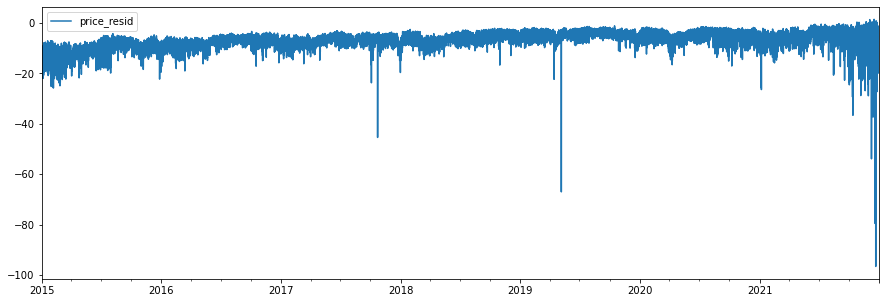

In [63]:
df.loc[:, ['price_resid']].plot(figsize=(15,5));